In [1]:
rm(list = ls())
suppressMessages(library(Matrix))
suppressMessages(library(parallel))
suppressMessages(library(compiler))
suppressMessages(library(lars))
suppressMessages(library(elasticnet))
options(warn=-1)
######
source('Functions/Auxiliar.r')
source('Functions/elastic_net_fit.r')
source('Functions/LOOCV.r')
source('Functions/KernelFunctions.r')
source('Functions/OutOfSample.r')
source('Functions/Interactions.R')
source('Functions/TrainingError.r')

#### Here is an example on how to compute the VCR nonparametrically from a multivariate time series using the regularized S-map

In [2]:
#################################### Declare names of model and Jacobians
FileName = 'inputFiles/deterministic_chaos_fc.txt'
JacobianName = 'inputFiles/jacobian_chaos_fc.txt'
#################################### Few initial parameters
### Kernel (choose between 1,2 or 3 for exponential, Epanechnikov and tri-cubic, respectively)
kernel.choice = 1. 
### L1/L2 norm for elastic net (from 0 to 1) set alpha = NULL if using ridge
alpha = 1.        
### Choose the regression type (you need to import the ridge.r file to run ridge regression)
RegressionType = 'ELNET_fit'
Kernel.Options = c('Exponential.Kernel', 'Epanechnikov.Kernel', 'TriCubic.Kernel')
Regression.Kernel = Kernel.Options[kernel.choice]
### Number of data points to use for inference
length.interval = 500
################################### Parameters for cross validation
logspace <- function(d1, d2, n) exp(log(10)*seq(d1, d2, length.out=n)) 
lambda = logspace(-5,0,15)                       
tht = logspace(-1.5,1.2,15)        
parameters_on_grid = expand.grid(tht, lambda)     
### Read Time series
d = ReadTimeSeries(FileName)
Embedding = LETTERS[1:ncol(d)] ### We take a full multivariate embedding
TargetList = Embedding
dfdx = expand.grid(TargetList, TargetList)

In [3]:
######################
t.min = 1
d.training = d[t.min:(t.min + length.interval - 1), ]
#### Make noise if you want
ObservationalNoise = F
if(isTRUE(ObservationalNoise))
  {
  d.training = d.training + matrix(rnorm(length(d.training),
                                   0,sd(d.training)*0.05), 
                                   nrow(d.training), ncol(d.training))   
  }
d.training = Standardizza(d.training)

#### Here we estimate the Jacobian coefficients with leave-one-out cross validation (it runs in parallel and it will take a while...)

In [4]:
#### Prepare for the fit in parallel (keep one core out)
Lavoratori = detectCores() - 1
cl <- makeCluster(Lavoratori, type = "FORK")
#### Run leave one out cross-validation
BestModel = LOO.CV(cl, d.training, TargetList, Embedding, 
                   parameters_on_grid, 
                   RegressionType,alpha, Regression.Kernel)
stopCluster(cl)

In [5]:
###### Coefficients of the Jacobian and intercepts
BestCoefficients = BestModel$BestCoefficients
###### Bandwith of the kernel (theta) and regularization parameter (lambda)
BestParameters = BestModel$BestParameters
###### Now check the quality of the inference
###### Important note: always check that the [interval] below is correct
rho = jacobiano_analitico(JacobianName,
                          BestCoefficients$J, 
                          ncol(d), 
                          t.min, t.min+length.interval-1) ### <-- [interval]
matrix.inference.rho = rho$correlation.matrix
###### Print and plot summary results
cat('Correlation coefficient between analytical and inferred VCR:', rho$trace.correlation, '\n')

Correlation coefficient between analytical and inferred VCR: 0.9528553 


#### Now make a plot to visualize analytical and inferred Volume Contraction Rates

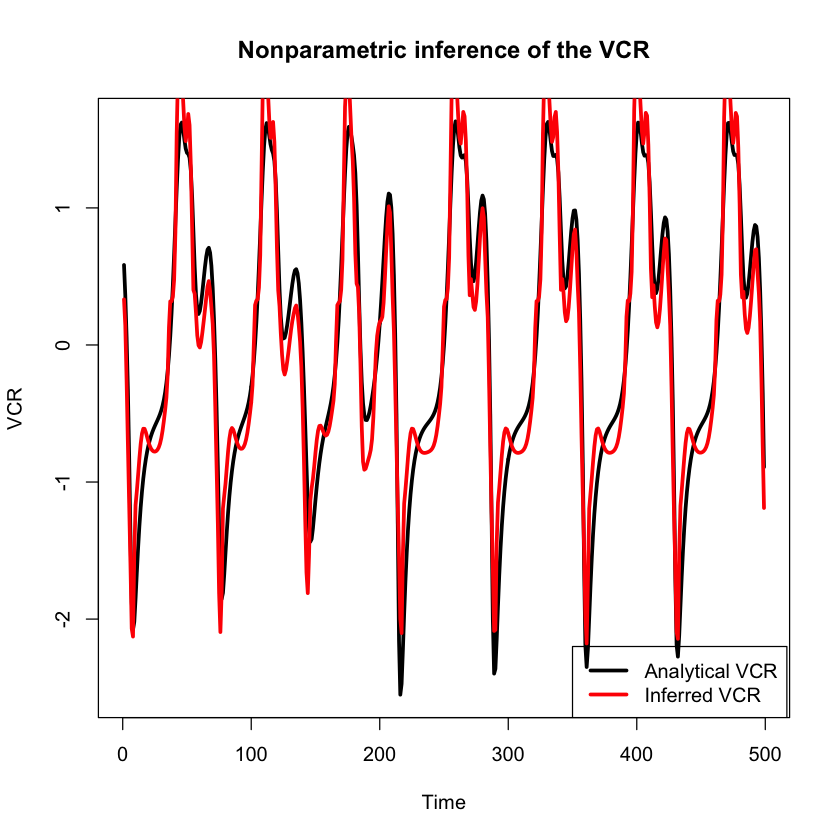

In [6]:
###### Notice that the VCR is scaled as we are only interested in the correct inference of the trend
plot(scale(rho$true.trace), type = 'l', lwd = 3, 
     xlab = 'Time', ylab = 'VCR', main = 'Nonparametric inference of the VCR')
lines(scale(rho$inferred.trace), col = 'red', lwd = 3)
legend(350, -2.2, c("Analytical VCR", "Inferred VCR"), lty = 1, lwd = 3, col = c('black', 'red'))